In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import os
import struct
import numpy as np
import pathlib
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.externals import joblib

# Data Import

In [3]:
"""
Loosely inspired by http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
which is GPL licensed.
"""

def read(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'newtrain-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'newtrain-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 'mnist-new1k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'mnist-new1k-labels-idx1-ubyte')
    else:
        raise Exception("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

In [4]:
tr = list(read("training", "newdata/"))
ts = list(read("testing", 'newdata/'))

images_train = np.array(list(zip(*tr))[1])
labels_train = np.array(list(zip(*tr))[0])

images_test = np.array(list(zip(*ts))[1])
labels_test = np.array(list(zip(*ts))[0])

print(images_train.shape)
print(labels_train.shape)
print(images_test.shape)
print(labels_test.shape)

y_train = labels_train
y_test = labels_test

(80000, 28, 28)
(80000,)
(10000, 28, 28)
(10000,)


In [5]:
def train_model(X, Y, model, default_param, param_grid, cv, save, filename):
    """
    Train model using given parameters.
    
    Arguments:
    ------------------------
    - X: training data images
    - Y: training data labels
    - model: estimator class (NOT object)
    - default_param: default parameters you want to apply to model
    - param_grid: used by GridSearchCV
    - cv: k in K-Fold. cross-validation parameter
    - save: whether you save trained model or not
    - filename: path of file to save your model
    
    Returns:
    ------------------------
    - estimator: trained model.
    """
    
    clf = model(**default_param)
    estimator = GridSearchCV(clf, param_grid, cv=cv, n_jobs=4)
    
    estimator.fit(X, Y)
    
    if save:
        joblib.dump(estimator, filename)
        
    return estimator

def get_model(model, filename, param_grid=dict(), cv=6, X=None, Y=None, default_param=dict(), force_training=False, save=True):
    """
    get model from existing file which has pre-trained model
    or create new model.
    
    Arguments:
    --------------------------
    - model: class of estimator
    - filename: name of file which contains pre-trained model.
    - default_param: default parameters you want to apply to model
    - param_grid: parameters you want to pass to GridSearchCV as parameters of 'param_grid'
    - cv: cross-validation parameter
    - X: training data images
    - Y: training data labels
    - forece_training: if you want this function to ONLY train not load from file, set True.
    - save: if you want to save model after training, set this True.
    
    Returns:
    --------------------------
    - estimator: model trained.
    """
    
    path = pathlib.Path(filename)
    estimator = None
    
    if force_training == True:
        estimator = train_model(X, Y, model, default_param, param_grid, cv, save, filename)
    else:
        if path.exists(): # if file exists, just load that.
            estimator = joblib.load(filename)
        else:
            estimator = train_model(X, Y, model, default_param, param_grid, cv, save, filename)
            
    return estimator

def get_model_without_gridsearch(model, filename, default_param=dict(), X=None, Y=None, save=True):
    """
    Another version of get model without GridSearchCV
    
    Arguments:
    -----------------------------
    model: class name of estimator
    filename: name of file to store our model into.
    default_param: default parameter you want to pass into model.
    X: features of training dataset
    Y: labels of training dataset
    save: if you want to save model after training, set it to True. default: True
    
    Returns:
    -----------------------------
    estimator: model which is trained already.
    """
    
    if pathlib.Path(filename).exists():
        estimator = joblib.load(filename)
    else:
        estimator = model(**default_param)
        estimator.fit(X, Y)
        if save:
            joblib.dump(estimator, filename)
        
    return estimator

# SVM implementation using SGD

In [6]:
class MySVM(BaseEstimator, ClassifierMixin):
    """
    1 vs 1 SVM (binary classification)
    """
    def __init__(self, C=0.1, eta=0.001, batch_size=1, max_iter=25, epsilon=1e-8):
        """
        constructor of MyBinarySVM class.
        """
        
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.eta = eta
        self.C = C
        self.epsilon = epsilon
        self.num_classes = 0
#         self.beta1 = 0.9
#         self.beta2 = 0.99
    
    def fit(self, X, y=None, params=None):
        """
        fit method for training svm
        
        Arguments:
        --------------------------
        X: image data. (60000, 784)
        y: label data. (60000, 1)
        
        Returns:
        --------------------------
        Z: class score
        """

        m = np.shape(X)[0]
        n = np.shape(X)[1]
        self.num_classes = len(np.unique(y))
        
        y_encoded = self.encode_y(y)
        
        # create weights.
        if params is None:
            self.params = {
                'W': np.random.randn(n, self.num_classes),
                'b': np.random.randn(1, self.num_classes)
            }
#             self.M = {
#                 'W': np.zeros((n, self.num_classes)),
#                 'b': np.zeros((1, self.num_classes))
#             }
#             self.V = {
#                 'W': np.zeros((n, self.num_classes)),
#                 'b': np.zeros((1, self.num_classes))
#             }

        cnt = 1
        
        # main loop: how much iterate on entire dataset.
        for epoch in range(self.max_iter):
            # before dive into SGD, shuffle dataset
            X_shuffled, y_shuffled = self.shuffle(X, y_encoded)
            
            # cost variable for printing/logging
            avg_loss = 0
            
            # batch_count = dataset_size / batch_size
            batch_count = int(np.ceil(np.shape(X)[0] / self.batch_size))
            
            # mini-batch loop
            for t in range(batch_count):
                # draw the {batch_size} number of samples from X and y
                X_batch, y_batch, bs = self.next_batch(X_shuffled, y_shuffled, t)
                
                # just in case, reshape batch of X and y into proper shape.
                X_batch = np.reshape(X_batch, (bs, n))
                y_batch = np.reshape(y_batch, (bs, self.num_classes))
                
                # prediction phase
                Z = self.forward_prop(X_batch)
                Z = np.reshape(Z, (bs, self.num_classes))
                
                # compute cost phase
                loss = self.compute_cost(y_batch, Z)
                
                # update weights phase
                self.backward_prop(X_batch, y_batch, Z, bs, cnt)
                
                # accumulate loss
                avg_loss += loss
                cnt += 1
        
            # logging
            avg_loss /= batch_count
            if epoch % (self.max_iter / 10) == 0:
                print('Cost at epoch {0}: {1}'.format(epoch, avg_loss))

        return self
    
    def encode_y(self, y):
        y_encoded = np.ones((np.shape(y)[0], self.num_classes))
        
        for i in range(self.num_classes):
            y_encoded[:, i][y != i] = -1
            
        return y_encoded
    
    def shuffle(self, X, y):
        """
        Random selection is required for SGD.
        But, my approach is to shuffle entire data before every iteration.
        This has same effect as random selection.
        
        Arguments:
        ---------------------------
        X: images (BATCH_SIZE, 784)
        y: labels (BATCH_SIZE, 1)
        
        Returns:
        ---------------------------
        shuffled data
        """
        
        # the number of dataset samples
        m = np.shape(X)[0]
        
        # variable for shuffle
        r = np.arange(0, m)
        
        np.random.shuffle(r)
        
        return X[r], y[r]
    
    def next_batch(self, X, y, t):
        """
        Get next batch.
        If it is SGD, next_batch function just pick one sample from dataset.
        
        Arguments:
        ---------------------------------
        X: images (60000, 784)
        y: labels (60000, 1)
        
        Returns:
        ---------------------------------
        X_batch: small subset of X (BATCH_SIZE, 784)
        y_batch: small subset of y (BATCH_SIZE, 1)
        """
        
        # the number of dataset samples
        m = np.shape(X)[0]
        
        # draw the {batch_size} number of samples from X and y
        X_batch = X[t * self.batch_size : min(m, (t + 1) * self.batch_size)]
        y_batch = y[t * self.batch_size : min(m, (t + 1) * self.batch_size)]
        bs = min(m, (t + 1) * self.batch_size) - t * self.batch_size
        
        return X_batch, y_batch, bs
    
    def forward_prop(self, X):
        """
        Process of inference (prediction).
        
        Arguments:
        -----------------------
        X: images e.g (BATCH_SIZE, 784)
        params: weights dictionary(map in other programming language)
        
        Returns:
        -----------------------
        A: 
        """
        
        # prediction
        Z = np.matmul(X, self.params['W']) + self.params['b']
        
        return Z
    
#     def sigmoid(self, Z):
#         """
#         sigmoid activation for binary classification
        
#         Arguments:
#         ----------------------
#         Z: class score (W.T * X)
        
#         Returns:
#         ----------------------
#         sigmoid activation
#         """
        
#         return 1 / (1 + np.exp(-Z))
    
    def compute_cost(self, y, Z):
        """
        compute cost function (loss function)
        
        Arguments:
        ------------------------------
        y: true label
        Z: class score (W.T * X)
        
        Returns:
        ------------------------------
        loss: total cost (loss)
        """
        
        # compute loss function
        temp = 1 - np.multiply(y, Z)
        temp[temp < 0] = 0
        loss = np.mean(temp)
        return loss
    
    def backward_prop(self, X, y, Z, bs, cnt):
        """
        update weights
        
        Arguments:
        ----------------------------
        X: images e.g (BATCH_SIZE, 784)
        y: labels e.g (BATCH_SIZE, 1)
        Z: class score after forward propagation
        params: weights dictionary(map in other programming language)
        eta: learning rate
        
        Returns:
        ----------------------------
        params: weights dictionary
        """
        
        # number of features
        n = np.shape(X)[1]
        
        # differential vector of loss function to update weights
        dw = np.zeros(self.params['W'].shape)
        db = np.zeros(self.params['b'].shape)
        
        Z = np.reshape(Z, (bs, self.num_classes))
        temp = np.multiply(y, Z)
        temp = 1 - temp
        
        temp[temp <= 0] = 0
        temp[temp > 0] = 1
        
        y_temp = np.multiply(y, temp.reshape(bs, self.num_classes))
        
        dw = -(1 / bs) * np.matmul(X.T, y_temp) + (1 / self.C) * self.params['W']
        db = -(1 / bs) * np.sum(y_temp, axis=0)

#         if cnt == 1:
#             self.M['W'] = dw
#             self.M['b'] = db
#         else:
#             self.M['W'] = (self.beta1 * self.M['W'] + (1 - self.beta1) * dw)
#             self.M['b'] = (self.beta1 * self.M['b'] + (1 - self.beta1) * db)
        
#         if cnt == 1:
#             self.V['W'] = dw ** 2
#             self.V['b'] = db ** 2
#         else:
#             self.V['W'] = (self.beta2 * self.V['W'] + (1 - self.beta2) * (dw ** 2))
#             self.V['b'] = (self.beta2 * self.V['b'] + (1 - self.beta2) * (db ** 2))
    
#         self.M['W'] = (self.beta1 * self.M['W'] + (1 - self.beta1) * dw) / (1 - self.beta1 ** cnt)
#         self.M['b'] = (self.beta1 * self.M['b'] + (1 - self.beta1) * db) / (1 - self.beta1 ** cnt)
        
#         self.V['W'] = (self.beta2 * self.V['W'] + (1 - self.beta2) * np.square(dw)) / (1 - self.beta2 ** cnt)
#         self.V['b'] = (self.beta2 * self.V['b'] + (1 - self.beta2) * np.square(db)) / (1 - self.beta2 ** cnt)

        # update weights
#         self.params['W'] = self.params['W'] - np.divide(self.eta * self.M['W'], np.sqrt(self.V['W']) + self.epsilon)
#         self.params['b'] = self.params['b'] - np.divide(self.eta * self.M['b'], np.sqrt(self.V['b']) + self.epsilon)
        
        self.params['W'] = self.params['W'] - (self.eta / (1 + self.epsilon * cnt)) * dw
        self.params['b'] = self.params['b'] - (self.eta / (1 + self.epsilon * cnt)) * db

#         self.params['W'] = self.params['W'] - (self.eta / (1 + self.epsilon * cnt)) * dw
#         self.params['b'] = self.params['b'] - (self.eta / (1 + self.epsilon * cnt)) * db
        
        return self.params
    
    def predict(self, X, y=None):
        m = np.shape(X)[0]
        
        class_score = self.forward_prop(X)
        pred = np.argmax(class_score, axis=1)
        
        return pred
    
    def score(self, X, y=None):
        pred = self.predict(X)
        score = np.mean(pred == y)
        
        return score
    
    def get_parameters(self):
        return self.params

# Gradient Features

In [7]:
def zero_padding(images, n=1):
    """
    zero-padding to image.
    add additional edge which has value of 0
    
    Arguments:
    ---------------------
    - images: training dataset images. maybe (60000, 28, 28)
    - n: how many padding do you want? in other word, how many edge do you want to insert?
    
    Returns:
    ---------------------
    - images_padded: padded images. (60000, 30, 30) or other shape.
    """
    
    # number of training examples. 60000. if you use test data, 10000.
    m = images.shape[0]
    
    # define larger size of window than size of images. maybe (60000, 30, 30), (60000, 32, 32)
    images_padded = np.zeros((m, images.shape[1] + 2 * n, images.shape[2] + 2 * n))
    
    # insert image in the middle of this window.
    images_padded[:, n : images_padded.shape[1] - n, n : images_padded.shape[2] - n] = images
    
    return images_padded

In [8]:
def x_gradient_slice(images_slice):
    """
    find gradient(in korean, 기울기 또는 미분값) for part of images.
    
    Arguments:
    ----------------------
    - images_slice: small window extracted from images. (60000, 7, 7)
    
    Returns:
    ----------------------
    - grad: x-axis-oriented gradient (in korean, x 축 방향 기울기)
    """
    
    x_gradient_filter = np.array([
        [-1,  0,  1],
        [-1,  0,  1],
        [-1,  0,  1],
    ])
    
    # reshape for broadcasting.
    x_gradient_filter = x_gradient_filter.reshape(1, 3, 3)
    
    # element-wise compute. compute gradient
    temp = np.multiply(images_slice, x_gradient_filter)
    grad = np.sum(temp, axis=(1, 2))
    
    return grad

In [9]:
def x_gradient(images):
    """
    find gradient(in korean, 기울기 또는 미분값) for whole images.
    
    Arguments:
    ----------------------
    - images: images. (60000, 28, 28)
    
    Returns:
    ----------------------
    - grad: x-axis-oriented gradient (in korean, x 축 방향 기울기)
    """
    
    # some useful variables.
    m = images.shape[0]
    width = images.shape[1]
    height = images.shape[2]
    
    # define placeholder to store gradients.
    x_grads = np.zeros((m, width - 2, height - 2))
    
    # slice image into small size window, then compute gradient.
    for w in range(1, width - 1):
        for h in range(1, height - 1):
            images_slice = images[:, w - 1 : w + 2, h - 1 : h + 2]
            x_grads[:, w - 1, h - 1] = x_gradient_slice(images_slice)
            
    return x_grads

In [10]:
def y_gradient_slice(images_slice):
    """
    find gradient(in korean, 기울기 또는 미분값) for part of images.
    
    Arguments:
    ----------------------
    - images_slice: small window extracted from images. (60000, 7, 7)
    
    Returns:
    ----------------------
    - grad: y-axis-oriented gradient (in korean, y 축 방향 기울기)
    """
    
    y_gradient_filter = np.array([
        [-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1],
    ])
    
    # reshape for broadcasting.
    y_gradient_filter = y_gradient_filter.reshape(1, 3, 3)
    
    # element-wise compute. compute gradient
    temp = np.multiply(images_slice, y_gradient_filter)
    grad = np.sum(temp, axis=(1, 2))
    
    return grad

In [11]:
def y_gradient(images):
    """
    find gradient(in korean, 기울기 또는 미분값) for whole images.
    
    Arguments:
    ----------------------
    - images: images. (60000, 28, 28)
    
    Returns:
    ----------------------
    - grad: y-axis-oriented gradient (in korean, y 축 방향 기울기)
    """
    
    # some useful variables.
    m = images.shape[0]
    width = images.shape[1]
    height = images.shape[2]
    
    # define placeholder to store gradients.
    y_grads = np.zeros((m, width - 2, height - 2))
    
    # slice image into small size window, then compute gradient.
    for w in range(1, width - 1):
        for h in range(1, height - 1):
            images_slice = images[:, w - 1 : w + 2, h - 1 : h + 2]
            y_grads[:, w - 1, h - 1] = y_gradient_slice(images_slice)
            
    return y_grads

In [12]:
def get_average_grads(x_grads, y_grads, grid=7):
    """
    After we get gradients, let's compute average of these gradient. I'will post pictures.
    compute partial gradients.
    
    Arguments:
    ---------------------
    - x_grads: pre-computed gradients for x-axis (60000, 28, 28)
    - y_grads: pre-computed gradients for y-axis (60000, 28, 28)
    - grid: grid for dividing images. we will compute average of gradients for each grid. the averages become features.
    
    Returns:
    ---------------------
    - x_avg_grads: average of gradients x-axis (60000, 7, 7)
    - y_avg_grads: average of gradients y-axis (60000, 7, 7)
    """
    
    assert(x_grads.shape == y_grads.shape)
    
    # some useful variables.
    m = x_grads.shape[0]
    width = x_grads.shape[1]
    height = x_grads.shape[2]
    
    # I define these variables to slicing images conveniently.
    w_step = width // grid  # w_step = 4
    h_step = height // grid # h_step = 4
    
    # placeholder for storing average of gradients
    x_avg_grads = np.zeros((m, width // w_step, height // h_step))
    y_avg_grads = np.zeros((m, width // w_step, height // h_step))
    
    for w in range(0, width, w_step):
        for h in range(0, height, h_step):
            # slicing gradients into small part.
            x_grads_slice = x_grads[:, w : w + w_step, h : h + h_step]
            y_grads_slice = y_grads[:, w : w + w_step, h : h + h_step]
            
            assert(x_grads_slice.shape == y_grads_slice.shape == (m, width // grid, height // grid))
            
            # compute mean of gradients of part of image
            x_avg_grads[:, w // w_step, h // h_step] = np.mean(x_grads_slice, axis=(1, 2))
            y_avg_grads[:, w // w_step, h // h_step] = np.mean(y_grads_slice, axis=(1, 2))
            
    return x_avg_grads, y_avg_grads

In [13]:
def average_gradients_grid(images, grid=7, padding=1, normalize=True):
    """
    Preprocessing method 1 which I tried.
    
    Arguments:
    -------------------------
    - images: training or test images (60000, 28, 28)
    - grid: grid for dividing images. we will compute average of gradients for each grid. the averages become features.
    - padding: how much padding image.
    
    Returns:
    -------------------------
    - features: pre-processed features (pixel of images). (60000, 98)
    """
    
    images = np.copy(images)
    
    m = images.shape[0]
    
    # normalize
    if normalize:
        images_norm = images / 255
    else:
        images_norm = images
    
    # thresholding
    images_norm[images_norm >= 0.1] = 1
    images_norm[images_norm < 0.1] = 0
    
    # zero padding
    images_padded = zero_padding(images_norm, padding)
    
    # number of features = grid^2 * 2
    features = np.zeros((m, (grid ** 2) * 2))

    # compute x-axis gradient, y-axis gradient
    x_grads = x_gradient(images_padded)
    y_grads = y_gradient(images_padded)
    
    # compute average of gradient (grid 7x7)
    x_avg_grads, y_avg_grads = get_average_grads(x_grads, y_grads, grid)
    
    assert(x_avg_grads.shape == y_avg_grads.shape == (m, grid, grid))
    
    # flatten
    x_features = x_avg_grads.reshape(m, -1)
    y_features = y_avg_grads.reshape(m, -1)
    
    features[:, 0 :: 2] = x_features
    features[:, 1 :: 2] = y_features
    
    return features

In [14]:
def apply_hog(images_train, images_test):
    m_tr = images_train.shape[0]
    m_ts = images_test.shape[0]
    
    # compute HoG (Historgram of Gradients)
    hog_train = np.zeros((m_tr, 81))
    hog_test = np.zeros((m_ts, 81))
    
    for i in range(m_tr):
        hog_train[i] = hog(images_train[i], block_norm='L2-Hys')
    for i in range(m_ts):
        hog_test[i] = hog(images_test[i], block_norm='L2-Hys')
        
    return hog_train, hog_test

In [15]:
def poly_model(grads, hogs, poly_degree):
    """
    This function reads inputs (grads, hogs) and then append into one vector.
    And, most importantly, make the features (grads + hogs vector) polynomial or exponential
    This has an effect that makes algorithm be applied to non-linear-separatable dataset.
    
    Arguments
    ---------------------------------
    grads: features containing gradients of images
    hogs: features containing histogram of gradients
    
    Returns
    ---------------------------------
    f_train: preprocessed features of training dataset this function generate
    f_test: preprocessed features of test dataset this function generate
    """
    
    # get number of training set (60000), number of test set (10000)
    m_train = grads[0].shape[0] # 60000
    m_test = grads[1].shape[0]  # 10000
    
#     # placeholder for new features.
#     f_train = np.zeros((m_train, (98 + 81) * poly_degree))
#     f_test = np.zeros((m_test, (98 + 81) * poly_degree)) 
    
    grads_train, grads_test = grads[0], grads[1]
    hogs_train, hogs_test = hogs[0], hogs[1]
    
#     for i in range(poly_degree):
#         f_train[:, (98 + 81) * i : (98 + 81) * i + 98] = grads_train ** (i + 1)
#         f_train[:, (98 + 81) * i + 98 : (98 + 81) * (i + 1)] = hogs_train ** (i + 1)
#         f_test[:, (98 + 81) * i : (98 + 81) * i + 98] = grads_test ** (i + 1)
#         f_test[:, (98 + 81) * i + 98 : (98 + 81) * (i + 1)] = hogs_test ** (i + 1)
        
    # 97.0
    f_train = np.zeros((m_train, (98 + 81) * poly_degree + 49 + 168 * 2))
    f_test = np.zeros((m_test, (98 + 81) * poly_degree + 49 + 168 * 2))
    
    
#     f_train = np.zeros((m_train, 98 * poly_degree + 168 * 2))
#     f_test = np.zeros((m_test, 98 * poly_degree + 168 * 2))
    
    for i in range(poly_degree):
        f_train[:, 98 * i : 98 * (i + 1)] = grads_train ** (i + 1)
        f_test[:, 98 * i : 98 * (i + 1)] = grads_test ** (i + 1)
    
    cur_w = 0
    cur_h = 0
    cur_idx = 98 * poly_degree
    
    while True:
        if cur_w == 7:
            cur_w = 0
            cur_h += 1
        if cur_h == 7:
            break
            
        # print(cur_h, cur_w)        
        
        if cur_w < 6:
            f_train[:, cur_idx] = np.multiply(grads_train[:, cur_h * 14 + cur_w * 2], grads_train[:, cur_h * 14 + cur_w * 2 + 2])
            f_test[:, cur_idx] = np.multiply(grads_test[:, cur_h * 14 + cur_w * 2], grads_test[:, cur_h * 14 + cur_w * 2 + 2])
            cur_idx += 1
            
            f_train[:, cur_idx] = np.multiply(grads_train[:, cur_h * 14 + cur_w * 2 + 1], grads_train[:, cur_h * 14 + cur_w * 2 + 3])
            f_test[:, cur_idx] = np.multiply(grads_test[:, cur_h * 14 + cur_w * 2 + 1], grads_test[:, cur_h * 14 + cur_w * 2 + 3])
            cur_idx += 1
            
        if cur_h < 6:
            f_train[:, cur_idx] = np.multiply(grads_train[:, cur_h * 14 + cur_w * 2], grads_train[:, cur_h * 14 + cur_w * 2 + 14])
            f_test[:, cur_idx] = np.multiply(grads_test[:, cur_h * 14 + cur_w * 2], grads_test[:, cur_h * 14 + cur_w * 2 + 14])
            cur_idx += 1
            
            f_train[:, cur_idx] = np.multiply(grads_train[:, cur_h * 14 + cur_w * 2 + 1], grads_train[:, cur_h * 14 + cur_w * 2 + 15])
            f_test[:, cur_idx] = np.multiply(grads_test[:, cur_h * 14 + cur_w * 2 + 1], grads_test[:, cur_h * 14 + cur_w * 2 + 15])
            cur_idx += 1
            
        cur_w += 1
            
    assert(cur_idx == 98 * poly_degree + 168)
    
    
    cur_w = 0
    cur_h = 0
    cur_idx = 98 * poly_degree + 168
    
    while True:
        if cur_w == 7:
            cur_w = 0
            cur_h += 1
        if cur_h == 7:
            break
            
        # print(cur_h, cur_w)        
        
        if cur_w < 6:
            f_train[:, cur_idx] = np.multiply(grads_train[:, cur_h * 14 + cur_w * 2]**2, grads_train[:, cur_h * 14 + cur_w * 2 + 2]**2)
            f_test[:, cur_idx] = np.multiply(grads_test[:, cur_h * 14 + cur_w * 2]**2, grads_test[:, cur_h * 14 + cur_w * 2 + 2]**2)
            cur_idx += 1
            
            f_train[:, cur_idx] = np.multiply(grads_train[:, cur_h * 14 + cur_w * 2 + 1]**2, grads_train[:, cur_h * 14 + cur_w * 2 + 3]**2)
            f_test[:, cur_idx] = np.multiply(grads_test[:, cur_h * 14 + cur_w * 2 + 1]**2, grads_test[:, cur_h * 14 + cur_w * 2 + 3]**2)
            cur_idx += 1
            
        if cur_h < 6:
            f_train[:, cur_idx] = np.multiply(grads_train[:, cur_h * 14 + cur_w * 2]**2, grads_train[:, cur_h * 14 + cur_w * 2 + 14]**2)
            f_test[:, cur_idx] = np.multiply(grads_test[:, cur_h * 14 + cur_w * 2]**2, grads_test[:, cur_h * 14 + cur_w * 2 + 14]**2)
            cur_idx += 1
            
            f_train[:, cur_idx] = np.multiply(grads_train[:, cur_h * 14 + cur_w * 2 + 1]**2, grads_train[:, cur_h * 14 + cur_w * 2 + 15]**2)
            f_test[:, cur_idx] = np.multiply(grads_test[:, cur_h * 14 + cur_w * 2 + 1]**2, grads_test[:, cur_h * 14 + cur_w * 2 + 15]**2)
            cur_idx += 1
            
        cur_w += 1
        
    assert(cur_idx == 98 * poly_degree + 168*2)
    
    f_train[:, cur_idx : cur_idx + 49] = np.multiply(grads_train[:, 0 :: 2], grads_train[:, 1 :: 2])
    f_test[:, cur_idx : cur_idx + 49] = np.multiply(grads_test[:, 0 :: 2], grads_test[:, 1 :: 2])
    
    cur_idx += 49
    
    for i in range(poly_degree):
        f_train[:, cur_idx + 81 * i : cur_idx + 81 * (i + 1)] = hogs_train  ** (i + 1)
        f_test[:, cur_idx + 81 * i : cur_idx + 81 * (i + 1)] = hogs_test ** (i + 1)
        
    cur_idx += 81 * poly_degree
    
    ### 97.0
        
    return f_train, f_test

In [16]:
def make_poly_features(images_train, images_test, poly_degree=3):
    """
    Arguments
    -------------------------
    images_train: images in training datase shaped of (60000, 28, 28)
    images_test: images in test dataset shaped of (10000, 28, 28)
    poly_degree: how many do you product exponentialy?
    
    Returns
    -------------------------
    f_train: new features preprocessed
    f_test: new features of test images.
    """
    
    m_train = images_train.shape[0]
    m_test = images_test.shape[0]
    
    # compute average of gradients
    avg_grads_train = average_gradients_grid(images_train)
    avg_grads_test = average_gradients_grid(images_test)
    
    hog_train, hog_test = apply_hog(images_train, images_test)
        
    f_train, f_test = poly_model((avg_grads_train, avg_grads_test), (hog_train, hog_test), poly_degree)
    
    return f_train, f_test

In [17]:
X_train1, X_test1 = make_poly_features(images_train, images_test)

print(X_train1.shape)
print(X_test1.shape)

(80000, 922)
(10000, 922)


In [21]:
X_train1_1, X_test1_1 = principal_component_analysis(X_train1, X_test1, n_components=200)

print(X_train1_1.shape)
print(X_test1_1.shape)

(80000, 200)
(10000, 200)


In [20]:
X_train1_1, X_test1_1 = principal_component_analysis

print(X_train1.shape)
print(X_test1.shape)

(80000, 1280)
(10000, 1280)


# Practice

## First Presentation (SGD)

In [184]:
svm1 = MyMultiClassSVM(C=0.1, batch_size=1, max_iter=100)
svm1.fit(images_train.reshape(-1, 784), labels_train)

===== class 0 =====
Cost at epoch 0: 10.686779661599083
Cost at epoch 20: 3.9106110524101063
Cost at epoch 40: 3.8943336857758077
Cost at epoch 60: 3.9469301067847753
Cost at epoch 80: 3.8709681574980714
===== class 1 =====
Cost at epoch 0: 7.776986236755182
Cost at epoch 20: 2.4891427342652643
Cost at epoch 40: 2.3798333476428706
Cost at epoch 60: 2.4464050664817494
Cost at epoch 80: 2.4073779035658793
===== class 2 =====
Cost at epoch 0: 15.264107177343247
Cost at epoch 20: 8.449161511196248
Cost at epoch 40: 8.63409637115864
Cost at epoch 60: 8.622411739425603
Cost at epoch 80: 8.464533323611493
===== class 3 =====
Cost at epoch 0: 18.280004966446374
Cost at epoch 20: 11.052509601646479
Cost at epoch 40: 10.850239516875225
Cost at epoch 60: 10.860347798842836
Cost at epoch 80: 10.90418745211039
===== class 4 =====
Cost at epoch 0: 12.627727763634088
Cost at epoch 20: 5.869691972435452
Cost at epoch 40: 5.920136742306459
Cost at epoch 60: 5.779820081917636
Cost at epoch 80: 5.7967893

MyMultiClassSVM(C=0.1, batch_size=1, max_iter=100)

In [185]:
svm1.score(images_train.reshape(-1, 784), labels_train)

0.82805

In [186]:
svm1.score(images_test.reshape(-1, 784), labels_test)

0.827

### After Second Presentation

### Without Poly

In [152]:
svm9 = MySVM(C=100, max_iter=10, batch_size=128, eta=0.1, epsilon=1e-6)
svm9.fit(images_train.reshape(-1, 784), labels_train)

Cost at epoch 0: 498.5804958412841
Cost at epoch 1: 359.10277278900776
Cost at epoch 2: 355.71068985186423
Cost at epoch 3: 359.609476224103
Cost at epoch 4: 356.2373117152157
Cost at epoch 5: 345.3893770677822
Cost at epoch 6: 355.2519745700933
Cost at epoch 7: 353.24436355337383
Cost at epoch 8: 356.68547173822924
Cost at epoch 9: 355.21175859380486


MySVM(C=100, batch_size=128, epsilon=1e-06, eta=0.1, max_iter=10)

In [153]:
print(svm9.score(images_train.reshape(-1, 784), labels_train))
print(svm9.score(images_test.reshape(-1, 784), labels_test))

0.82295
0.8261


### With Poly

In [154]:
svm10 = MySVM(C=100, max_iter=10, batch_size=128, eta=0.1, epsilon=1e-6)
svm10.fit(X_train1, y_train)

Cost at epoch 0: 0.5035333226658423
Cost at epoch 1: 0.10438156594947337
Cost at epoch 2: 0.06016534104111028
Cost at epoch 3: 0.04570331757865704
Cost at epoch 4: 0.04146340068239925
Cost at epoch 5: 0.03995063634935078
Cost at epoch 6: 0.03954779149909941
Cost at epoch 7: 0.03932526051044747
Cost at epoch 8: 0.039288615859364814
Cost at epoch 9: 0.03920007023660946


MySVM(C=100, batch_size=128, epsilon=1e-06, eta=0.1, max_iter=10)

In [155]:
print(svm10.score(X_train1, y_train))
print(svm10.score(X_test1, y_test))

0.94905
0.9541


In [22]:
svm11 = MySVM(C=1000, max_iter=140, batch_size=128, eta=0.1)
svm11.fit(X_train1, y_train)

Cost at epoch 0: 0.4868896166333449
Cost at epoch 14: 0.034642926555208654
Cost at epoch 28: 0.024553674948518237
Cost at epoch 42: 0.023249654502907918
Cost at epoch 56: 0.023045071307159416
Cost at epoch 70: 0.02292480221704541
Cost at epoch 84: 0.022888446619541123
Cost at epoch 98: 0.022854011039341877
Cost at epoch 112: 0.022835906738977757
Cost at epoch 126: 0.022808043309768867


MySVM(C=1000, batch_size=128, epsilon=1e-08, eta=0.1, max_iter=140)

In [23]:
print(svm11.score(X_train1, y_train))
print(svm11.score(X_test1, y_test))

0.9707833333333333
0.9692


In [209]:
svm12 = MySVM(C=1000, max_iter=150, batch_size=256, eta=0.1, epsilon=1e-6)
svm12.fit(X_train1, y_train)

Cost at epoch 0: 0.7334484125818558
Cost at epoch 15: 0.05274669657420555
Cost at epoch 30: 0.03216483529590398
Cost at epoch 45: 0.025873836753252496
Cost at epoch 60: 0.02370003559416378
Cost at epoch 75: 0.022996210569053436
Cost at epoch 90: 0.02262936586380937
Cost at epoch 105: 0.0225053841804381
Cost at epoch 120: 0.022413567913048153
Cost at epoch 135: 0.02226538391143299


MySVM(C=1000, batch_size=256, epsilon=1e-06, eta=0.1, max_iter=150)

In [210]:
print(svm12.score(X_train1, y_train))
print(svm12.score(X_test1, y_test))

0.9715
0.9704


In [204]:
svm12 = MySVM(C=5000, max_iter=60, batch_size=128, eta=0.5)
svm12.fit(X_train1, y_train)

Cost at epoch 0: 0.23133134841341058
Cost at epoch 6: 0.03466896102249104
Cost at epoch 12: 0.025818586243018006
Cost at epoch 18: 0.022909658473664194
Cost at epoch 24: 0.02202936745164572
Cost at epoch 30: 0.021419137597926453
Cost at epoch 36: 0.021065128861031145
Cost at epoch 42: 0.021047066704588894
Cost at epoch 48: 0.020946851930114262
Cost at epoch 54: 0.020999108051241756


MySVM(C=5000, batch_size=128, eta=0.5, max_iter=60)

In [205]:
print(svm12.score(X_train1, y_train))
print(svm12.score(X_test1, y_test))

0.97465
0.9721


In [206]:
svm13 = MySVM(C=3000, max_iter=60, batch_size=128, eta=0.5)
svm13.fit(X_train1, y_train)

Cost at epoch 0: 0.2183647436927403
Cost at epoch 6: 0.03171837887838108
Cost at epoch 12: 0.02544136402485873
Cost at epoch 18: 0.02415090152977139
Cost at epoch 24: 0.0236846273495908
Cost at epoch 30: 0.02317945789227962
Cost at epoch 36: 0.02319328806980065
Cost at epoch 42: 0.023551674518366005
Cost at epoch 48: 0.023035735109379247
Cost at epoch 54: 0.023318888672678104


MySVM(C=3000, batch_size=128, eta=0.5, max_iter=60)

In [207]:
print(svm13.score(X_train1, y_train))
print(svm13.score(X_test1, y_test))

0.9673166666666667
0.9645


In [159]:
svm14 = MySVM(C=1500, max_iter=160, batch_size=128, eta=0.1, epsilon=1e-6)
svm14.fit(X_train1, y_train)

Cost at epoch 0: 0.5178958171835167
Cost at epoch 16: 0.03581916261548705
Cost at epoch 32: 0.024306085129678332
Cost at epoch 48: 0.021984525199011534
Cost at epoch 64: 0.021376543774205965
Cost at epoch 80: 0.0211023774133448
Cost at epoch 96: 0.020948865127737144
Cost at epoch 112: 0.020879688687241153
Cost at epoch 128: 0.0208613647427255
Cost at epoch 144: 0.020786574306057504


MySVM(C=1500, batch_size=128, epsilon=1e-06, eta=0.1, max_iter=160)

In [161]:
print(svm14.score(X_train1, y_train))
print(svm14.score(X_test1, y_test))

0.9737833333333333
0.9706


## With Grid Search 

In [26]:
param_grid = {
    'C': [100, 300, 1000, 3000],
    'batch_size': [128, 256, 512],
    'max_iter': [60, 100, 140],
    'epsilon': [1e-8, 1e-6],
    'eta': [0.1]
}

svm15 = get_model(MySVM, 'data/MySVM3.data', param_grid=param_grid, X=X_train1_1, Y=y_train)

Cost at epoch 0: 0.5062394022425962
Cost at epoch 10: 0.055337102693834635
Cost at epoch 20: 0.03557037364159835
Cost at epoch 30: 0.028561444389302318
Cost at epoch 40: 0.02545134005411057
Cost at epoch 50: 0.024058577126849626
Cost at epoch 60: 0.023363414666039913
Cost at epoch 70: 0.02307407703963969
Cost at epoch 80: 0.022848414855454954
Cost at epoch 90: 0.02281231330480708


In [30]:
svm15.best_params_

{'C': 3000, 'batch_size': 128, 'epsilon': 1e-06, 'eta': 0.1, 'max_iter': 100}

In [28]:
print(svm15.score(X_train1_1, y_train))
print(svm15.score(X_test1_1, y_test))

0.96955
0.9678


In [31]:
param_grid = {
    'C': [2500, 3000, 3500, 4000],
    'batch_size': [128, 256],
    'max_iter': [60, 100, 140],
    'epsilon': [1e-8, 1e-6],
    'eta': [0.1]
}

svm16 = get_model(MySVM, 'data/MySVM4.data', param_grid=param_grid, X=X_train1_2, Y=y_train)

Cost at epoch 0: 0.4124635042119067
Cost at epoch 14: 0.05287199149041953
Cost at epoch 28: 0.043367706013074596
Cost at epoch 42: 0.04060016037574976
Cost at epoch 56: 0.03951733258821541
Cost at epoch 70: 0.03897316008802417
Cost at epoch 84: 0.038694802772646156
Cost at epoch 98: 0.038487977965632435
Cost at epoch 112: 0.03840115744979289
Cost at epoch 126: 0.038281154735352485


In [33]:
svm16.best_score_

0.9412333333333334

In [128]:
param_grid = {
    'C': [100, 300, 1000, 3000],
    'batch_size': [128, 256, 512],
    'max_iter': [60, 100, 140],
    'epsilon': [1e-8, 1e-6],
    'eta': [0.1]
}

svm29 = get_model(MySVM, 'data/MySVM1.data', param_grid=param_grid, X=X_train1, Y=y_train)

In [129]:
print(svm29.best_score_)
print(svm29.best_params_)
print(svm29.best_estimator_.get_parameters())

print(svm29.best_estimator_.score(X_train1, y_train))
print(svm29.best_estimator_.score(X_test1, y_test))

0.9704833333333334
{'C': 3000, 'batch_size': 128, 'epsilon': 1e-06, 'eta': 0.1, 'max_iter': 140}
{'W': array([[ 0.13710753,  0.11072044,  0.30610425, ..., -0.01590253,
        -0.19389575,  0.06185292],
       [ 0.19278389, -0.04250993,  0.13152295, ...,  0.10308245,
        -0.08123604,  0.05646114],
       [ 0.14558454, -0.13749245, -0.05957599, ..., -0.07933711,
         0.12258241, -0.08383579],
       ...,
       [ 0.09188823,  0.13741366,  0.27188086, ...,  0.08381936,
        -0.15180401, -0.00396859],
       [-0.19813818, -0.13988205,  0.0035366 , ..., -0.19149217,
        -0.00095808, -0.1070209 ],
       [ 0.08765961,  0.11305135,  0.21979072, ..., -0.02604575,
        -0.06398772, -0.10612421]]), 'b': array([[-1.66203954,  0.10457154, -0.98303182, -1.73397415, -2.6234894 ,
        -0.1175283 , -1.73561003, -1.41792256, -3.94602472, -1.82123815]])}
0.9766
0.9721


In [130]:
pd.DataFrame(svm29.cv_results_).to_csv('MySVM_svm29_train1.csv')

D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\util

In [131]:
print(svm29.best_estimator_.get_parameters())

{'W': array([[ 0.13710753,  0.11072044,  0.30610425, ..., -0.01590253,
        -0.19389575,  0.06185292],
       [ 0.19278389, -0.04250993,  0.13152295, ...,  0.10308245,
        -0.08123604,  0.05646114],
       [ 0.14558454, -0.13749245, -0.05957599, ..., -0.07933711,
         0.12258241, -0.08383579],
       ...,
       [ 0.09188823,  0.13741366,  0.27188086, ...,  0.08381936,
        -0.15180401, -0.00396859],
       [-0.19813818, -0.13988205,  0.0035366 , ..., -0.19149217,
        -0.00095808, -0.1070209 ],
       [ 0.08765961,  0.11305135,  0.21979072, ..., -0.02604575,
        -0.06398772, -0.10612421]]), 'b': array([[-1.66203954,  0.10457154, -0.98303182, -1.73397415, -2.6234894 ,
        -0.1175283 , -1.73561003, -1.41792256, -3.94602472, -1.82123815]])}


In [133]:
param_grid = {
    'C': [3000, 3500, 4000],
    'batch_size': [128],
    'max_iter': [100, 140],
    'epsilon': [1e-6, 1e-5],
    'eta': [0.1]
}

svm18 = get_model(MySVM, 'data/MySVM2.data', param_grid=param_grid, X=X_train1, Y=y_train)

In [134]:
print(svm18.best_score_)
print(svm18.best_params_)
print(svm18.best_estimator_.get_parameters())

print(svm18.best_estimator_.score(X_train1, y_train))
print(svm18.best_estimator_.score(X_test1, y_test))

0.9708833333333333
{'C': 3500, 'batch_size': 128, 'epsilon': 1e-05, 'eta': 0.1, 'max_iter': 140}
{'W': array([[-0.11721773,  0.14751221,  0.13017908, ..., -0.3987127 ,
         0.08624766,  0.20424375],
       [ 0.17146778,  0.1471984 , -0.3955672 , ..., -0.22600087,
         0.01635417, -0.22803647],
       [ 0.12696431,  0.00186481,  0.0494665 , ...,  0.15406404,
         0.07941765, -0.40508291],
       ...,
       [ 0.28410379, -0.1196908 , -0.21759334, ..., -0.14378999,
        -0.01747923, -0.16902245],
       [ 0.16176322,  0.10714409,  0.04208303, ..., -0.06643455,
        -0.07328502, -0.27009435],
       [ 0.03130327,  0.42317872, -0.23258921, ..., -0.11655082,
         0.28603592,  0.07569481]]), 'b': array([[-1.44205315,  0.71676242, -0.48244117, -1.53739799, -2.80475429,
         0.56763092, -1.59692785, -0.76808621, -3.22254488, -2.0419439 ]])}
0.97745
0.9738


In [135]:
pd.DataFrame(svm18.cv_results_).to_csv('MySVM_svm18_train1.csv')

D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\util

In [136]:
print(svm18.best_estimator_.get_parameters())

{'W': array([[-0.11721773,  0.14751221,  0.13017908, ..., -0.3987127 ,
         0.08624766,  0.20424375],
       [ 0.17146778,  0.1471984 , -0.3955672 , ..., -0.22600087,
         0.01635417, -0.22803647],
       [ 0.12696431,  0.00186481,  0.0494665 , ...,  0.15406404,
         0.07941765, -0.40508291],
       ...,
       [ 0.28410379, -0.1196908 , -0.21759334, ..., -0.14378999,
        -0.01747923, -0.16902245],
       [ 0.16176322,  0.10714409,  0.04208303, ..., -0.06643455,
        -0.07328502, -0.27009435],
       [ 0.03130327,  0.42317872, -0.23258921, ..., -0.11655082,
         0.28603592,  0.07569481]]), 'b': array([[-1.44205315,  0.71676242, -0.48244117, -1.53739799, -2.80475429,
         0.56763092, -1.59692785, -0.76808621, -3.22254488, -2.0419439 ]])}


In [125]:
param_grid = {
    'C': [3400, 3500, 3600],
    'batch_size': [128],
    'max_iter': [120, 140, 160],
    'epsilon': [1e-6, 1e-5, 1e-4],
    'eta': [0.1]
}

svm17 = get_model(MySVM, 'data/MySVM5.data', param_grid=param_grid, X=X_train1, Y=y_train)

In [127]:
print(svm17.best_score_)
print(svm17.best_params_)
print(svm17.best_estimator_.get_parameters())
print(svm17.best_estimator_.score(X_train1, y_train))
print(svm17.best_estimator_.score(X_test1, y_test))

0.9712666666666666
{'C': 3600, 'batch_size': 128, 'epsilon': 1e-06, 'eta': 0.1, 'max_iter': 140}
{'W': array([[-0.11151751,  0.2135294 ,  0.20382278, ...,  0.19694961,
        -0.15845842, -0.20904872],
       [ 0.15784837, -0.15899147, -0.03681736, ..., -0.02858646,
        -0.26898294,  0.04704171],
       [-0.12895156, -0.06816802, -0.14374408, ..., -0.27802178,
        -0.20643542,  0.05486333],
       ...,
       [-0.11276817, -0.0532217 ,  0.35935393, ..., -0.18056679,
         0.08705596,  0.01626816],
       [-0.16559266,  0.21541088, -0.24065934, ..., -0.09622628,
        -0.28852436, -0.31122237],
       [-0.42192208,  0.46062478,  0.17556587, ..., -0.16914525,
         0.11211911, -0.22515615]]), 'b': array([[-1.37395103, -0.1101466 , -0.44808261, -1.97124803, -1.90238104,
        -0.22335933, -2.50026859, -1.4679542 , -4.21234812, -1.89847586]])}
0.9775166666666667
0.9728


In [137]:
pd.DataFrame(svm17.cv_results_).to_csv('MySVM_svm17_train1.csv')

In [167]:
svm30 = MySVM(C=1000, batch_size=256, epsilon=1e-6, eta=0.1, max_iter=480)
svm30.fit(X_train1, y_train)

Cost at epoch 0: 0.7435422788784037
Cost at epoch 48: 0.025371965849831566
Cost at epoch 96: 0.022632816324009774
Cost at epoch 144: 0.02227781977520921
Cost at epoch 192: 0.022211862480572175
Cost at epoch 240: 0.022144778804264124
Cost at epoch 288: 0.02211765380968727
Cost at epoch 336: 0.022079472011284768
Cost at epoch 384: 0.022108294652347656
Cost at epoch 432: 0.02211495649570549


MySVM(C=1000, batch_size=256, epsilon=1e-06, eta=0.1, max_iter=480)

In [168]:
print(svm30.score(X_train1, y_train))
print(svm30.score(X_test1, y_test))

0.9719
0.9701


In [19]:
def centerize(X):
    X_center = np.zeros(np.shape(X))
    mu = np.zeros((1, np.shape(X)[1]))
    
    mu[0, :] = np.mean(X, axis=0)
        
    X_center = X - mu
    
    return X_center

In [8]:
def SVD_like(mat):
    
    eig_val, eig_vec = np.linalg.eig(mat)
    
    eig_pair = [(eig_val[i], eig_vec[i]) for i in range(len(eig_val))]
    
    sorted(eig_pair, key=lambda p: p[0], reverse=True)
    sorted_eig_vec = [eig_pair[i][1] for i in range(len(eig_pair))]
    
    return np.array(sorted_eig_vec)

In [20]:
def principal_component_analysis(X_train, X_test=None, n_components=150):
    
    X_train_centered = centerize(X_train)
    
#     eig_vec = SVD_like(np.cov(X_train_centered.T))
    
#     reduced_eig_vec = eig_vec[:, : n_components]
    
#     reduced_train = np.matmul(X_train, reduced_eig_vec)
#     reduced_test = np.matmul(X_test, reduced_eig_vec)
    
#     assert(reduced_train.shape == (X_train.shape[0], n_components))
    
#     return reduced_train, reduced_test

    u, s, v = np.linalg.svd(np.cov(X_train_centered.T))
    u_reduced = u[:, : n_components]
    
    reduced_train = np.matmul(X_train, u_reduced)
    if X_test is not None:
        reduced_test = np.matmul(X_test, u_reduced)
        return reduced_train, reduced_test
    
    return reduced_train

In [32]:
def linear_discriminant_analysis(X_train, y_train, X_test, n_components=150):
    num_classes = len(np.unique(y_train))
    mu = np.zeros((num_classes, np.shape(X_train)[1]))
    total_mu = np.zeros((1, np.shape(X_train)[1]))
    
    Sw = np.zeros((np.shape(X_train)[1], np.shape(X_train)[1]))
    Sb = np.zeros((np.shape(X_train)[1], np.shape(X_train)[1]))
    
    for i in range(num_classes):
        mu[i, :] = np.mean(X_train[y_train == i], axis=0)
    total_mu[0, :] = np.mean(mu, axis=0)
    
    for i in range(num_classes):
        temp_w = mu[i, :].reshape(-1, 1) - total_mu.reshape(-1, 1)
        Sw += np.matmul(temp_w, temp_w.T)
        
        temp = X_train[y_train == i].T - mu[i, :].reshape(-1, 1)
        temp_b = np.sum(temp, axis=1) / (np.sum(y_train == i) - 1)
        Sb += np.matmul(temp_b, temp_b.T)
        
#     eig_vec = SVD_like(np.matmul(np.linalg.inv(Sw), Sb))
    eig_vec, s, v = np.linalg.svd(np.matmul(np.linalg.inv(Sw), Sb))
    reduced_eig_vec = eig_vec[:, : n_components]
    
    reduced_train = np.matmul(X_train, reduced_eig_vec)
    reduced_test = np.matmul(X_test, reduced_eig_vec)
    
    return reduced_train, reduced_test

In [33]:
def make_poly_features2(images_train, labels_train, images_test):
    
    m_train = images_train.shape[0]
    m_test = images_test.shape[0]
    
    f_train = np.zeros((m_train, 550))
    f_test = np.zeros((m_test, 550))
    
    X_train = np.reshape(images_train, (-1, 784))
    X_test = np.reshape(images_test, (-1, 784))
    
    X_train, X_test = make_poly_features(images_train, images_test)
    
    f_train[:, : 100], f_test[:, : 100] = principal_component_analysis(images_train.reshape(-1, 784) / 255, images_test.reshape(-1, 784) / 255, n_components=100)
#     f_train[:, 100 : 200] = f_train[:, : 100] ** 2
#     f_test[:, 100 : 200] = f_test[:, : 100] ** 2
#     f_train[:, 200 : 300] = f_train[:, : 100] ** 3
#     f_test[:, 200 : 300] = f_test[:, : 100] ** 3
    f_train[:, 100 :], f_test[:, 100 :] = linear_discriminant_analysis(X_train, labels_train, X_test, n_components=450)
    
    return f_train, f_test

In [34]:
X_train1_1, X_test1_1 = principal_component_analysis(X_train1, X_test1, n_components=300)
print(X_train1_1.shape, X_test1_1.shape)

(60000, 300) (10000, 300)


In [35]:
X_train1_2, X_test1_2 = linear_discriminant_analysis(X_train1, y_train, X_test1, n_components=300)
print(X_train1_2.shape, X_test1_2.shape)

(60000, 300) (10000, 300)


In [37]:
X_train2_1, X_test2_1 = principal_component_analysis(X_train2, X_test2, n_components=300)
print(X_train2_1.shape, X_test2_1.shape)

(60000, 300) (10000, 300)


In [38]:
X_train2_2, X_test2_2 = linear_discriminant_analysis(X_train2, y_train, X_test2, n_components=300)
print(X_train2_2.shape, X_test2_2.shape)

(60000, 300) (10000, 300)


In [241]:
X_train3, X_test3 = make_poly_features2(images_train, labels_train, images_test)
print(X_train3.shape, X_test3.shape)

(60000, 550) (10000, 550)


In [42]:
# svm16 = MySVM(C=800, max_iter=100, batch_size=256, eta=0.1)
# svm16.fit(X_train3, y_train)

param_grid = {
    'C': [1000, 3000, 5000],
    'batch_size': [128],
    'max_iter': [100, 140],
    'epsilon': [1e-6, 1e-5],
    'eta': [0.1]
}

svm19 = get_model(MySVM, 'data/MySVM_pca_2.data', param_grid=param_grid, X=X_train2_1, Y=y_train)

Cost at epoch 0: 0.6411737075465398
Cost at epoch 14: 0.05123676151659059
Cost at epoch 28: 0.03468459339797425
Cost at epoch 42: 0.02896198244484556
Cost at epoch 56: 0.026464435237825296
Cost at epoch 70: 0.0251863590123125
Cost at epoch 84: 0.024494619136511978
Cost at epoch 98: 0.02404701991799214
Cost at epoch 112: 0.023648399115464198
Cost at epoch 126: 0.023475562961978017


In [44]:
print(svm19.best_score_)
print(svm19.best_params_)
print(svm19.best_estimator_.get_parameters())

print(svm19.best_estimator_.score(X_train2_1, y_train))
print(svm19.best_estimator_.score(X_test2_1, y_test))

0.9612
{'C': 5000, 'batch_size': 128, 'epsilon': 1e-05, 'eta': 0.1, 'max_iter': 140}
{'W': array([[-0.21390191,  0.46890821, -0.07465975, ...,  0.39427718,
         0.22347838,  0.22881381],
       [-0.0680663 , -0.50260387, -0.24228425, ...,  0.17769017,
        -0.01774631,  0.31676386],
       [-0.25198895, -0.07480761, -0.01799079, ...,  0.08800352,
        -0.07044982,  0.12783986],
       ...,
       [-0.00290697,  0.38822286,  0.04721271, ..., -0.20181268,
        -0.668893  , -0.16160831],
       [-0.45113114,  0.16841665,  0.27420922, ...,  0.74060221,
        -0.45420076,  0.14166384],
       [ 0.04835054,  0.42510864, -0.51964888, ...,  0.41421658,
        -0.12295242, -0.22585462]]), 'b': array([[-1.52612183,  0.39331909, -1.8532421 , -2.71426455, -2.9569455 ,
        -0.49953788, -2.06171755, -1.57328481, -3.49586168, -2.54507266]])}
0.9692
0.9654


In [46]:
df = pd.DataFrame(svm19.cv_results_)

D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\util

In [47]:
df.to_csv('svm19_pca_2.csv')

In [364]:
# svm16 = MySVM(C=800, max_iter=100, batch_size=256, eta=0.1)
# svm16.fit(X_train3, y_train)

param_grid = {
    'C': [1000, 3000, 5000],
    'batch_size': [128],
    'max_iter': [100, 140],
    'epsilon': [1e-6, 1e-5],
    'eta': [0.1]
}

svm18 = get_model(MySVM, 'data/MySVM_pca_1.data', param_grid=param_grid, X=X_train1_1, Y=y_train)

Cost at epoch 0: 0.48932683295464136
Cost at epoch 14: 0.04419559353360848
Cost at epoch 28: 0.02880823164261982
Cost at epoch 42: 0.023278789820220348
Cost at epoch 56: 0.020860258709197253
Cost at epoch 70: 0.01963223788157185
Cost at epoch 84: 0.01898376376060766
Cost at epoch 98: 0.018647284956326685
Cost at epoch 112: 0.01849057621098567
Cost at epoch 126: 0.018309819412845294


MySVM(C=3000, batch_size=128, epsilon=1e-06, eta=0.1, max_iter=140)

In [48]:
print(svm18.best_score_)
print(svm18.best_params_)
print(svm18.best_estimator_.get_parameters())

print(svm18.best_estimator_.score(X_train1_1, y_train))
print(svm18.best_estimator_.score(X_test1_1, y_test))

0.9643166666666667
{'C': 5000, 'batch_size': 128, 'epsilon': 1e-06, 'eta': 0.1, 'max_iter': 140}
{'W': array([[ 0.32812412, -0.67099888,  0.00908884, ..., -0.45744519,
        -0.31934168, -0.10684607],
       [-0.16833774, -0.385851  , -0.32817532, ...,  0.467464  ,
         0.05119359,  0.51386786],
       [-0.3559464 , -0.06851864, -0.07286901, ...,  0.14226421,
        -0.15123767,  0.1769827 ],
       ...,
       [-0.53217675, -0.01356341,  0.37574779, ..., -0.15770324,
        -0.30678296,  0.70073816],
       [ 0.32655044, -0.42132501, -0.04976439, ...,  0.30219391,
         0.41638435, -0.15553092],
       [ 0.09011209,  0.26667697,  0.18750308, ...,  0.26438093,
        -0.62708056, -0.41335652]]), 'b': array([[-1.7067485 ,  0.16843686, -1.14272568, -2.81020837, -3.06580705,
        -0.44149976, -1.89194673, -1.55026339, -3.08337275, -2.29915054]])}
0.9707666666666667
0.9675


In [49]:
df = pd.DataFrame(svm18.cv_results_)
df.to_csv('svm18_pca_1.csv')

D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\util

# Plot

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

## Without learning rate decay

In [23]:
svm21 = MySVM(C=3500, max_iter=100, batch_size=128, eta=0.1)
svm21.fit(X_train1, y_train)

Cost at epoch 0: 0.5004672507202607
Cost at epoch 10: 0.05134592662546951
Cost at epoch 20: 0.03343726607192031
Cost at epoch 30: 0.0266278815669175
Cost at epoch 40: 0.0233338041017626
Cost at epoch 50: 0.021649595190985683
Cost at epoch 60: 0.02067620977447049
Cost at epoch 70: 0.02017142012884437
Cost at epoch 80: 0.019821455581828188
Cost at epoch 90: 0.019595970609721635


MySVM(C=3500, batch_size=128, epsilon=1e-08, eta=0.1, max_iter=100)

In [24]:
print(svm21.score(X_train1, y_train))
print(svm21.score(X_test1, y_test))

0.975675
0.964


In [59]:
svm22 = MySVM(C=3500, max_iter=140, batch_size=128, eta=0.1)
svm22.fit(X_train2, y_train)

Cost at epoch 0: 0.6286434202204312
Cost at epoch 14: 0.05016631249522425
Cost at epoch 28: 0.031766432269513846
Cost at epoch 42: 0.02507985418714191
Cost at epoch 56: 0.02199970980531646
Cost at epoch 70: 0.020416188305290454
Cost at epoch 84: 0.019631569975251766
Cost at epoch 98: 0.019167804076441225
Cost at epoch 112: 0.018831380530505575
Cost at epoch 126: 0.018724202787300467


MySVM(C=3500, batch_size=128, epsilon=1e-08, eta=0.1, max_iter=140)

In [60]:
print(svm22.score(X_train2, y_train))
print(svm22.score(X_test2, y_test))

0.9753833333333334
0.9718


### PCA version

In [61]:
svm23 = MySVM(C=3500, max_iter=140, batch_size=128, eta=0.1)
svm23.fit(X_train1_1, y_train)

Cost at epoch 0: 0.5279850300148776
Cost at epoch 14: 0.04469477023314208
Cost at epoch 28: 0.029430569284351886
Cost at epoch 42: 0.02494266396091238
Cost at epoch 56: 0.023346218007564676
Cost at epoch 70: 0.022784549209448657
Cost at epoch 84: 0.022495127485833245
Cost at epoch 98: 0.022404386725391696
Cost at epoch 112: 0.022323744190876297
Cost at epoch 126: 0.0223217885468603


MySVM(C=3500, batch_size=128, epsilon=1e-08, eta=0.1, max_iter=140)

In [62]:
print(svm23.score(X_train1_1, y_train))
print(svm23.score(X_test1_1, y_test))

0.9698833333333333
0.9683


In [63]:
svm24 = MySVM(C=3500, max_iter=140, batch_size=128, eta=0.1)
svm24.fit(X_train2_1, y_train)

Cost at epoch 0: 0.6210781295022839
Cost at epoch 14: 0.048014652193324035
Cost at epoch 28: 0.03186326403404652
Cost at epoch 42: 0.027480261131487504
Cost at epoch 56: 0.025842778429804005
Cost at epoch 70: 0.02538987910184618
Cost at epoch 84: 0.025089065914957902
Cost at epoch 98: 0.02496420578231034
Cost at epoch 112: 0.024940744751733687
Cost at epoch 126: 0.02479058452007617


MySVM(C=3500, batch_size=128, epsilon=1e-08, eta=0.1, max_iter=140)

In [64]:
print(svm24.score(X_train2_1, y_train))
print(svm24.score(X_test2_1, y_test))

0.9678833333333333
0.9638


## With learning rate decay

In [66]:
svm25 = MySVM(C=3500, max_iter=140, batch_size=128, eta=0.1)
svm25.fit(X_train1, y_train)

Cost at epoch 0: 0.5567875355996388
Cost at epoch 14: 0.046294531345514534
Cost at epoch 28: 0.029704094545581976
Cost at epoch 42: 0.023618518156009058
Cost at epoch 56: 0.020926683615308788
Cost at epoch 70: 0.019542757227408468
Cost at epoch 84: 0.018758194536583866
Cost at epoch 98: 0.018291841266288522
Cost at epoch 112: 0.017999659656631282
Cost at epoch 126: 0.017883131581233443


MySVM(C=3500, batch_size=128, epsilon=1e-08, eta=0.1, max_iter=140)

In [67]:
print(svm25.score(X_train1, y_train))
print(svm25.score(X_test1, y_test))

0.9774166666666667
0.9727


In [68]:
svm26 = MySVM(C=3500, max_iter=140, batch_size=128, eta=0.1)
svm26.fit(X_train2, y_train)

Cost at epoch 0: 0.6338581500761664
Cost at epoch 14: 0.050874106168308196
Cost at epoch 28: 0.03214584988938263
Cost at epoch 42: 0.025356649337598403
Cost at epoch 56: 0.022284647293940276
Cost at epoch 70: 0.02066506016669776
Cost at epoch 84: 0.01968927535622095
Cost at epoch 98: 0.01916811546637401
Cost at epoch 112: 0.018837767567501034
Cost at epoch 126: 0.018697693767661946


MySVM(C=3500, batch_size=128, epsilon=1e-08, eta=0.1, max_iter=140)

In [69]:
print(svm26.score(X_train2, y_train))
print(svm26.score(X_test2, y_test))

0.9748666666666667
0.9693


### PCA version

In [70]:
svm27 = MySVM(C=3500, max_iter=140, batch_size=128, eta=0.1)
svm27.fit(X_train1_1, y_train)

Cost at epoch 0: 0.5000327333377631
Cost at epoch 14: 0.04484374174463349
Cost at epoch 28: 0.030086810667382783
Cost at epoch 42: 0.02534807354088641
Cost at epoch 56: 0.02364159493797155
Cost at epoch 70: 0.02288923122558651
Cost at epoch 84: 0.02262021094151225
Cost at epoch 98: 0.022475709608005018
Cost at epoch 112: 0.022399396095785444
Cost at epoch 126: 0.022377660304338146


MySVM(C=3500, batch_size=128, epsilon=1e-08, eta=0.1, max_iter=140)

In [71]:
print(svm27.score(X_train1_1, y_train))
print(svm27.score(X_test1_1, y_test))

0.9697666666666667
0.9675


In [72]:
svm28 = MySVM(C=3500, max_iter=140, batch_size=128, eta=0.1)
svm28.fit(X_train2_1, y_train)

Cost at epoch 0: 0.6313096979437539
Cost at epoch 14: 0.047376759586617356
Cost at epoch 28: 0.0319893447928701
Cost at epoch 42: 0.027594463977368554
Cost at epoch 56: 0.025936456109261655
Cost at epoch 70: 0.02521580983213248
Cost at epoch 84: 0.025078552246877238
Cost at epoch 98: 0.024943205383054005
Cost at epoch 112: 0.02502725979881426
Cost at epoch 126: 0.024808768563934724


MySVM(C=3500, batch_size=128, epsilon=1e-08, eta=0.1, max_iter=140)

In [73]:
print(svm28.score(X_train2_1, y_train))
print(svm28.score(X_test2_1, y_test))

0.9673666666666667
0.9654


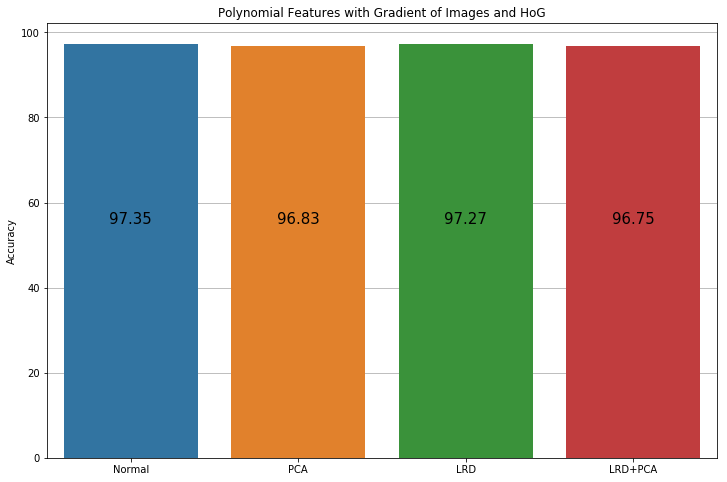

In [121]:
fig, ax = plt.subplots(figsize=(12, 8))

style = dict(size=15, color='black', zorder=20)

sns.barplot(x=['Normal', 'PCA', 'LRD', 'LRD+PCA'], y=[97.35, 96.83, 97.27, 96.75], ax=ax, zorder=10)
ax.text(0, 55, '97.35', ha='center', **style)
ax.text(1, 55, '96.83', ha='center', **style)
ax.text(2, 55, '97.27', ha='center', **style)
ax.text(3, 55, '96.75', ha='center', **style)
ax.grid(True, axis='y', zorder=0)

plt.title('Polynomial Features with Gradient of Images and HoG')
plt.ylabel('Accuracy')

plt.show()

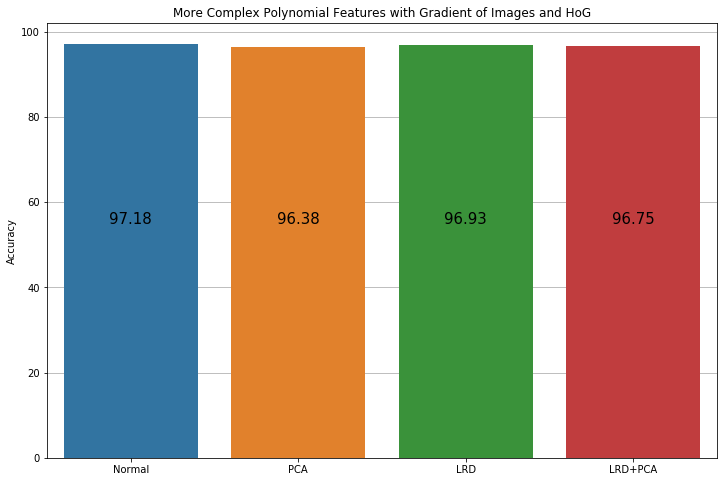

In [122]:
fig, ax = plt.subplots(figsize=(12, 8))

style = dict(size=15, color='black', zorder=20)

sns.barplot(x=['Normal', 'PCA', 'LRD', 'LRD+PCA'], y=[97.18, 96.38, 96.93, 96.54], ax=ax, zorder=10)
ax.text(0, 55, '97.18', ha='center', **style)
ax.text(1, 55, '96.38', ha='center', **style)
ax.text(2, 55, '96.93', ha='center', **style)
ax.text(3, 55, '96.75', ha='center', **style)
ax.grid(True, axis='y', zorder=0)

plt.title('More Complex Polynomial Features with Gradient of Images and HoG')
plt.ylabel('Accuracy')

plt.show()

# Using NEW data

In [29]:
svm31 = MySVM(C=10, max_iter=200, batch_size=256, eta=0.1, epsilon=1e-6)
svm31.fit(X_train1, y_train)

Cost at epoch 0: 0.32940399194849806
Cost at epoch 20: 0.07332278851076657
Cost at epoch 40: 0.07322536171102914
Cost at epoch 60: 0.07340241195812529
Cost at epoch 80: 0.07316462392616682
Cost at epoch 100: 0.0732092184078106
Cost at epoch 120: 0.07307172336236248
Cost at epoch 140: 0.07305519105185415
Cost at epoch 160: 0.07325391808665663
Cost at epoch 180: 0.07322504224066118


MySVM(C=10, batch_size=256, epsilon=1e-06, eta=0.1, max_iter=200)

In [30]:
print(svm31.score(X_train1, y_train))
print(svm31.score(X_test1, y_test))

0.8931
0.8504


In [32]:
svm32 = MySVM(C=2000, batch_size=128, epsilon=1e-6, eta=0.1, max_iter=140)
svm32.fit(X_train1, y_train)

Cost at epoch 0: 0.49875536922754554
Cost at epoch 14: 0.03682432274994522
Cost at epoch 28: 0.02509577029149028
Cost at epoch 42: 0.02259840237150455
Cost at epoch 56: 0.021824809720563502
Cost at epoch 70: 0.021565624179254627
Cost at epoch 84: 0.021462587448148152
Cost at epoch 98: 0.02138001465017672
Cost at epoch 112: 0.021287241444508904
Cost at epoch 126: 0.0212716677614172


MySVM(C=2000, batch_size=128, epsilon=1e-06, eta=0.1, max_iter=140)

In [33]:
print(svm32.score(X_train1, y_train))
print(svm32.score(X_test1, y_test))

0.974075
0.9611


In [51]:
svm33 = MySVM(C=3000, batch_size=128, epsilon=1e-6, eta=0.1, max_iter=120)
svm33.fit(X_train1, y_train)

Cost at epoch 0: 0.46169277901930755
Cost at epoch 12: 0.044314241645463257
Cost at epoch 24: 0.029027493930966052
Cost at epoch 36: 0.02382230281136949
Cost at epoch 48: 0.021682122975913348
Cost at epoch 60: 0.020769815721963004
Cost at epoch 72: 0.020343427162660407
Cost at epoch 84: 0.02007903576596676
Cost at epoch 96: 0.019859341339561236
Cost at epoch 108: 0.019781534153832873


MySVM(C=3000, batch_size=128, epsilon=1e-06, eta=0.1, max_iter=120)

In [52]:
print(svm33.score(X_train1, y_train))
print(svm33.score(X_test1, y_test))

0.9751375
0.9634


In [58]:
images_train[0].shape

(28, 28)

In [93]:
param_grid = {
    'C': [2500, 3000, 3500],
    'batch_size': [128, 256],
    'max_iter': [80, 100, 120],
    'epsilon': [1e-6, 1e-5, 1e-4],
    'eta': [0.1]
}

svm34 = get_model(MySVM, 'data/MySVM6.data', param_grid=param_grid, X=X_train1, Y=y_train)

Cost at epoch 0: 0.46661067859120386
Cost at epoch 12: 0.04575007107003653
Cost at epoch 24: 0.030189782790959498
Cost at epoch 36: 0.024789191963618642
Cost at epoch 48: 0.02237083389387941
Cost at epoch 60: 0.021199653905492884
Cost at epoch 72: 0.020547962872874165
Cost at epoch 84: 0.02017684544487005
Cost at epoch 96: 0.01985304061151586
Cost at epoch 108: 0.01969957457583046


In [94]:
print(svm34.best_score_)
print(svm34.best_params_)
print(svm34.best_estimator_.get_parameters())

print(svm34.best_estimator_.score(X_train1, y_train))
print(svm34.best_estimator_.score(X_test1, y_test))

0.969125
{'C': 3000, 'batch_size': 128, 'epsilon': 1e-05, 'eta': 0.1, 'max_iter': 120}
{'W': array([[-0.16582055,  0.12977394, -0.02721224, ..., -0.06322164,
         0.07951149,  0.14110873],
       [ 0.12207459, -0.20273143, -0.0151158 , ...,  0.21847416,
        -0.0488652 , -0.25587117],
       [-0.08006568,  0.01578766,  0.1302908 , ...,  0.05152386,
        -0.17710384, -0.20635521],
       ...,
       [-0.07328833, -0.01133344,  0.01258361, ..., -0.01713797,
        -0.20738709, -0.16110956],
       [-0.27871563, -0.07699144,  0.38529885, ..., -0.11907301,
        -0.06123669, -0.06525174],
       [ 0.06123447,  0.2709687 ,  0.07144766, ..., -0.23807059,
        -0.05570399, -0.00112006]]), 'b': array([[-1.4007554 ,  0.27122374, -1.04808382, -2.48286222, -2.58446761,
        -0.21125334, -1.73920687, -1.0860246 , -3.84951094, -1.52165789]])}
0.9757875
0.9643


In [ ]:
param_grid = {
    'C': [2800, 3000, 3200],
    'batch_size': [128],
    'max_iter': [110, 120, 130],
    'epsilon': [1e-5],
    'eta': [0.1]
}

svm34 = get_model(MySVM, 'data/MySVM7.data', param_grid=param_grid, X=X_train1, Y=y_train)

In [ ]:
print(svm34.best_score_)
print(svm34.best_params_)
print(svm34.best_estimator_.get_parameters())

print(svm34.best_estimator_.score(X_train1, y_train))
print(svm34.best_estimator_.score(X_test1, y_test))

# Additional Trial

In [18]:
svm35 = MySVM(C=2500, eta=0.1, batch_size=128, epsilon=1e-6, max_iter=140)
svm35.fit(X_train1, y_train)

Cost at epoch 0: 0.488409216743553
Cost at epoch 14: 0.040187730037779465
Cost at epoch 28: 0.02640411788586003
Cost at epoch 42: 0.02267565884221039
Cost at epoch 56: 0.021380735829661292
Cost at epoch 70: 0.020900626498853506
Cost at epoch 84: 0.020721446815663017
Cost at epoch 98: 0.020513668595483706
Cost at epoch 112: 0.02044506708983655
Cost at epoch 126: 0.0203983816494079


MySVM(C=2500, batch_size=128, epsilon=1e-06, eta=0.1, max_iter=140)

In [21]:
# print(svm35.best_score_)
# print(svm35.best_params_)
# print(svm35.best_estimator_.get_parameters())

print(svm35.score(X_train1, y_train))
print(svm35.score(X_test1, y_test))

0.9748125
0.9632
